<a href="https://colab.research.google.com/github/RosaliaGimenezBDS/M9_Reto_2/blob/main/Reto_2_M09_Notebook_1_y_2_seguidos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 2** - (Notebook 1/4)
Autor: **Meysam Madadi**

Colaborador: **Julio C. S. Jacques Junior**

---

# **Reto 2:** Predicción de personalidad aparente usando aprendizaje profundo y datos multimodales

En esta práctica, construiremos diferentes modelos para **predecir la personalidad aparente** de los individuos a partir de múltiples tipos de datos. Es decir, las etiquetas (valores de personalidad) fueron anotadas por observadores externos. Nuestro primer modelo utilizará únicamente **información textual** obtenida de las transcripciones de los videos de entrada. Nuestro segundo modelo utilizará **información visual** (algunas imágenes para cada entrada de video). Finalmente, combinaremos texto e información visual en un **enfoque multimodal**.


# **Objetivo general**
- Manejar datos multimodales.
- Desarrollar una rede multimodal utilizando una estrategia de fusión sencilla.
- Comparar diferentes enfoques, basados en texto, imágenes y una combinación de ellos para la predicción de la personalidad.








# **Los objetivos de este Jupyter notebook**
- Conocer el conjunto de datos y visualizarlo.
- Aprender a extraer características de los datos de texto.

## Nota IMPORTANTE
- En este *Jupyter Notebook*, preprocesamos los datos textuales (transcripciones de videos) para **extraer características del lenguaje natural**. Primero, analizamos el texto y lo dividimos en oraciones. Luego, cada oración se descompone en sus componentes (palabras y símbolos), los cuales se utilizan como entrada para el algoritmo de extracción de características.
- Como veréis, analizar información de texto y preprocesarla puede ser un poco complejo. El objetivo de este Jupyter Notebook es proporcionar el código y la explicación para el ejemplo/práctica dado, y **no profundizar en los detalles del preprocesamiento**, ya que se podrían usar diferentes estrategias.


# **Conjunto de datos**
- Usamos un subconjunto del conjunto de datos [**First Impressions**](https://chalearnlap.cvc.uab.cat/dataset/24/description/) para este reto. Está compuesto por 6000 clips (con una duración promedio de 15 segundos cada uno) extraídos de más de 3000 videos de alta definición, de personas frente a una cámara y hablando en inglés. Los videos se dividen en conjuntos de entrenamiento, validación y prueba con una proporción de 4:1:1. Las personas en los videos muestran diferentes géneros, edades y etnias.
- Los videos están etiquetados con variables de rasgos de personalidad. Los rasgos de personalidad considerados fueron los del Modelo de “Five Factor” (también conocido como los “**Big-Five**”). Este modelo describe la personalidad humana a lo largo de cinco dimensiones: **“Openness”**, **“Conscientiousness”**, **“Extraversion”**, **“Agreeableness”**, y **“Neuroticism”**. En este conjunto de datos, “Neuroticism” fue anotado como “Emotional stability”, es decir, lo opuesto al neuroticismo. Cada clip tiene etiquetas para estos cinco rasgos representados con un valor dentro del rango [0, 1]. Las transcripciones de los videos también se proporcionan en el conjunto de datos como modalidad adicional a los videos.
- **Para poder trabajar con los datos en un tiempo razonable en Colab, preprocesamos los datos**. Es decir, se extrajeron 4 imágenes RGB de cada videoclip, igualmente espaciadas. También procesamos las transcripciones de video usando el modelo [BERT](https://pypi.org/project/pytorch-pretrained-bert/) y extraemos características por palabra. El código de esta parte está disponible en este Jupyter Notebook como material complementario.

- Los datos (información visual y transcripciones) preprocesados se descargan desde nuestro servidor en la siguiente celda. Las transcripciones se han guardado como un diccionario en el que las claves son los nombres de los videos. A continuación, visualizamos una muestra como ejemplo de datos.

In [1]:
# Download and unzip the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/data_final.zip
!unzip ./data_final.zip

# Download video transcriptions
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/train-transcription.zip
!unzip train-transcription.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
   creating: data_final/validation/QJcc95Y0XPw.002/
  inflating: data_final/validation/QJcc95Y0XPw.002/001.jpg  
  inflating: data_final/validation/QJcc95Y0XPw.002/115.jpg  
  inflating: data_final/validation/QJcc95Y0XPw.002/229.jpg  
  inflating: data_final/validation/QJcc95Y0XPw.002/343.jpg  
  inflating: data_final/validation/QJcc95Y0XPw.002/annotation.npy  
  inflating: data_final/validation/QJcc95Y0XPw.002/transcription_features.npy  
   creating: data_final/validation/qjU3GX3jgSY.002/
  inflating: data_final/validation/qjU3GX3jgSY.002/001.jpg  
  inflating: data_final/validation/qjU3GX3jgSY.002/115.jpg  
  inflating: data_final/validation/qjU3GX3jgSY.002/229.jpg  
  inflating: data_final/validation/qjU3GX3jgSY.002/343.jpg  
  inflating: data_final/validation/qjU3GX3jgSY.002/annotation.npy  
  inflating: data_final/validation/qjU3GX3jgSY.002/transcription_features.npy  
   creating: data_final/validation/qjU3GX3jgSY.003/




Transcription is:
Probably go with that. It's safety always first. We know the areas that we're walking in, or going on foot in. You need to be able to take responsibility for that event. If the shit hits ...

Apparent personality labels are:
extraversion	neuroticism	agreeableness	conscientiousness	openness
0.69		0.75		0.84		0.88			0.76		


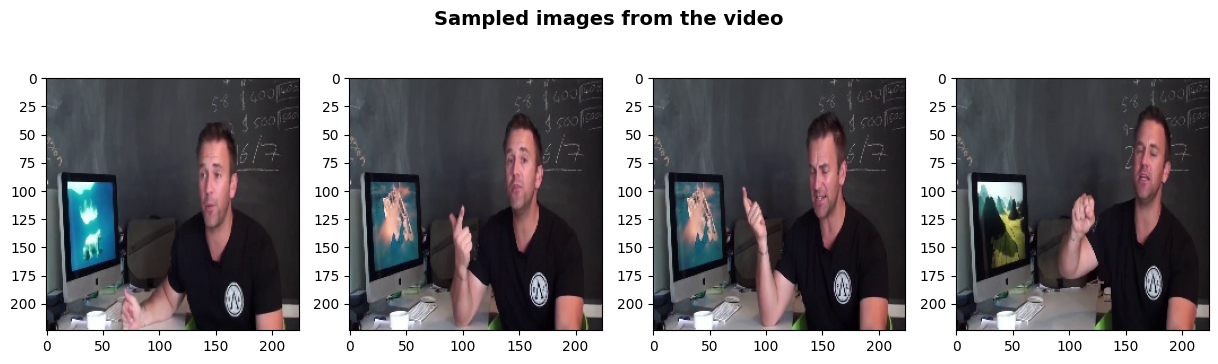

In [8]:
# Visualize a sample data
# You can change "vid_name" to another valid filenames (from train set) to visualize other samples

from glob import glob
import cv2
import numpy as np
import pickle
from matplotlib import pyplot as plt

root = './data_final/train/'
vid_name = '2oEUp9sGRGk.000'

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
fig.suptitle('Sampled images from the video', fontsize=14, fontweight='bold')

# reading and showing images
files = sorted(glob(root+vid_name+'/*.jpg'))
for i in range(4):
  img = cv2.imread(files[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  eval('ax'+str(i+1)).imshow(img)

# reading and printing the transcription
trans = pickle.load(open('transcription_training.pkl','rb'))
print('\n\n\nTranscription is:')
print(trans[vid_name+'.mp4'])

# reading and printing the personality labels
traits = np.load(open(root+vid_name+'/annotation.npy', 'rb'))
print('\nApparent personality labels are:')
print('extraversion\tneuroticism\tagreeableness\tconscientiousness\topenness')
print('{0:0.2f}\t\t{1:0.2f}\t\t{2:0.2f}\t\t{3:0.2f}\t\t\t{4:0.2f}\t\t'.format(traits[0],traits[1],traits[2],traits[3],traits[4]))

# **Procesamiento de Lenguaje Natural (*NLP*): Extracción de características de texto**

Existen diferentes maneras de extraer características de texto. Por ejemplo: 1) ["bag of words"](https://machinelearningmastery.com/gentle-introduction-bag-words-model/), 2) ["word2vec"](https://www.kdnuggets.com/2021/11/guide-word-embedding-techniques-nlp.html) y 3) redes ["Transformers"](https://www.kdnuggets.com/2021/11/guide-word-embedding-techniques-nlp.html) basadas en aprendizaje profundo. "Bag of words" crea vectores enormes y no densos, haciendo que las mediciones de similitud sean una tarea difícil. Además, los vectores están predefinidos y no tienen en cuenta el contexto de la oración. "Word2vec" resuelve algunos problemas de "bag of words". Sin embargo, una palabra con significados diferentes puede tener la misma representación ("*embeddings*"). En este Reto usaremos la tercera opción, que no tiene estos problemas. El primer modelo de este tipo se llama BERT. Usaremos un modelo BERT preentrenado para extraer representaciones de palabras ("*embeddings*"), como se describe a continuación.

## Instalando la biblioteca BERT

Primero, instalamos la biblioteca [pytorch-pretrained-bert](https://pypi.org/project/pytorch-pretrained-bert/), que contiene varios modelos de lenguaje preentrenado, incluidos BERT y GPT.


In [3]:
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 9.0 MB/s eta 0:00:00


# **Preprocesamiento de datos ("*parsing*"):**

## Analizando y preprocesando las transcripciones

- A continuación, definimos una función básica para analizar y dividir las transcripciones en oraciones. Para esto, utilizamos delimitadores simples para encontrar el final de una oración: "**?**", "**!**" y "**.**". Las transcripciones pueden no tener un delimitador al final o pueden comenzar o terminar con "**...**". Estos casos también se manejan en la función definida.
- Para mostrar al BERT el **inicio/final** de una oración, también se agregan "símbolos especiales" a las oraciones, "**[CLS]**" y "**[SEP]**".
- Un ejemplo de cómo un archivo de transcripción se divide en oraciones se muestra al final de esta celda (después de ejecutarla).

In [4]:
# Split the text into sentences
def split(text):
  indices = []
  for delimiter in ['?','!','.']:
    # Start searching for the substring from the beginning of the string
    start_index = 0
    # Continue searching until the substring is not found in the remaining part of the string
    while True:
        # Find the next occurrence of the substring starting from the current start_index
        index = text.find(delimiter, start_index)
        if index == -1:
            # If the substring is not found, break out of the loop
            break
        else:
            # If the substring is found, add its start index to the list of indices
            indices.append(index)
            # Update the start index to start searching for the next occurrence of the substring
            start_index = index + 1

  # Remove indices with '...' delimiter that detected above
  indices2remove = []
  # Start searching for the substring from the beginning of the string
  start_index = 0
  # Continue searching until the substring is not found in the remaining part of the string
  while True:
      # Find the next occurrence of the substring starting from the current start_index
      index = text.find('...', start_index)
      if index == -1:
          # If the substring is not found, break out of the loop
          break
      else:
          # If the substring is found, add its start index to the list of indices
          indices2remove.append(index)
          indices2remove.append(index+1)
          indices2remove.append(index+2)
          # Update the start index to start searching for the next occurrence of the substring
          start_index = index + 3
  for i in indices2remove:
    indices.remove(i)

  if len(indices) == 0: return ["[CLS] " + text + " [SEP]"]

  # Sort the indices
  indices = sorted(indices)
  indices = [-1]+indices if indices[-1]==len(text)-1 else [-1]+indices+[len(text)]

  # Start spliting the sentences
  # [CLS] and [SEP] are required to identify the begin and end.
  sentences = []
  for i in range(len(indices)-1):
    sentences.append("[CLS] " + text[indices[i]+1:indices[i+1]+1] + " [SEP]")

  return sentences


###########################################
# An example of how the sentences are splitted
###########################################
text = "Who was Jim Henson? Jim Henson was a puppeteer."
text = split(text)
print(text)

['[CLS] Who was Jim Henson? [SEP]', '[CLS]  Jim Henson was a puppeteer. [SEP]']


## Cargando el modelo pre-entrenado y los datos

- BERT tiene varios modelos preentrenados, que se pueden categorizar según el idioma 1) idioma (inglés, chino y multilingüe), 2) el uso de mayúsculas y minúsculas (con o sin mayúsculas) y 3) el tamaño del modelo (con 12 capas o grande con 24 capas). En este Reto, usaremos el modelo "**bert-base-uncased**" que está entrenado para oraciones en inglés en minúsculas ("*uncased*").
- La entrada del modelo será una secuencia de palabras y símbolos. El proceso de convertir una oración en sus componentes se llama "**tokenization**" y también lo maneja la biblioteca.


In [5]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
import pickle
import numpy as np

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
# If GPU is available, put everything on cuda to speed up feature extraction
if torch.cuda.is_available():
  model.to('cuda')

# Load transcriptions into a dictionary
# Keys are video names
trans = pickle.load(open('transcription_training.pkl','rb'))
keys = trans.keys()


100%|██████████| 407873900/407873900 [00:40<00:00, 10180482.00B/s]
/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/modeling.py:603: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

## Extracción de características

- A continuación, extraemos características de texto utilizando el modelo BERT, utilizando un bucle para iterar sobre cada transcripción de video, y otro para iterar sobre cada oración de la transcripción.
- La entrada a BERT es una secuencia de texto "*tokenizado*".
- Como salida, se toma la representación ("*embedding*") de la última capa: **un vector de tamaño 768 para cada "*token*"**.
- **Al final, se apilan las características de todos los "*tokens*" para cada transcripción de video.**
- NOTA: cada transcripción tiene un número diferente de palabras y símbolos ("*tokens*") y, por lo tanto, **el vector de características de salida de cada muestra de dato tiene una longitud variable** entre todas las muestras del conjunto de datos.


In [6]:
# A loop over video transcriptions
for i, k in enumerate(keys):

  # Note that "split" is the funcion we defined before
  text = split(trans[k])

  features = []
  # A loop over sentences
  for s in text:
    print(str(i)+" "+k+": "+s)
    # Tokenized input
    tokenized_text = tokenizer.tokenize(s)

    # Convert token to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])

    # If GPU is available, put everything on cuda to speed up feature extraction
    if torch.cuda.is_available():
      tokens_tensor = tokens_tensor.to('cuda')

    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, output_all_encoded_layers=False)

    # Accumulate encoded layers for all sentences
    # Discard [CLS] and [SEP] tokens
    features.append(encoded_layers.cpu().numpy()[:, 1:-1, :])

    # printing the feature size of each transcript (for debug purpose)
    aux = features[-1]
    print("Feature size (sentence):", np.array(aux).shape)

  # stack all sentences
  features = np.concatenate(features, axis=1)

  print("Feature size (transcript):", features.shape)
  print("----")

  # The processed features (of each transcript) are already saved in our server
  # and will be loadead later by the other notebook files
  # This process of feature extraction is shown for illustration purpose only.

Se han truncado las últimas 5000 líneas del flujo de salida.
5439 2f7rLXwzP3s.002.mp4: [CLS]  It's extremely hard to not compare yourself to others when we're surrounded by Instagram, Facebook, Twitter, even Youtube, but as long as you're self-assure and you respect yourself, you are- [SEP]
Feature size (sentence): (1, 45, 768)
Feature size (transcript): (1, 65, 768)
----
5440 PVm7Om88BSw.003.mp4: [CLS] ... In the room is actually a teacher. [SEP]
Feature size (sentence): (1, 11, 768)
5440 PVm7Om88BSw.003.mp4: [CLS]  We all learn from each other. [SEP]
Feature size (sentence): (1, 7, 768)
5440 PVm7Om88BSw.003.mp4: [CLS]  There's nobody higher and mightier than the other. [SEP]
Feature size (sentence): (1, 12, 768)
5440 PVm7Om88BSw.003.mp4: [CLS]  We learn every day. [SEP]
Feature size (sentence): (1, 5, 768)
5440 PVm7Om88BSw.003.mp4: [CLS]  Every time we run a course to the class, we learn from you guys on the screen. [SEP]
Feature size (sentence): (1, 19, 768)
5440 PVm7Om88BSw.003.mp4

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 2** - (Notebook 2/4)
Autor: **Meysam Madadi**

Colaborador: **Julio C. S. Jacques Junior**

---

# **Los objetivos de este Jupyter notebook**
- Crear nuestro primer modelo utilizando información de texto como entrada.
- Comparar dos estrategias de fusión de características:
 - utilizando un modelo secuencial (LSTM)
 - utilizando el valor promedio
- Predecir la personalidad aparente a partir de datos textuales.
- Visualizar los resultados.

## **Descargando y descomprimiendo los datos**
- Aunque se descargue el conjunto de datos preprocesado completo, en este *notebook* solo trabajaremos con datos textuales (es decir, características de transcripción de video extraídas por BERT).

In [9]:
# Download and unzip the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/data_final.zip
!unzip ./data_final.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data_final/validation/pQy4omHIf7o.001/115.jpg  
  inflating: data_final/validation/pQy4omHIf7o.001/229.jpg  
  inflating: data_final/validation/pQy4omHIf7o.001/343.jpg  
  inflating: data_final/validation/pQy4omHIf7o.001/annotation.npy  
  inflating: data_final/validation/pQy4omHIf7o.001/transcription_features.npy  
  inflating: data_final/validation/pQy4omHIf7o.002/001.jpg  
  inflating: data_final/validation/pQy4omHIf7o.002/115.jpg  
  inflating: data_final/validation/pQy4omHIf7o.002/229.jpg  
  inflating: data_final/validation/pQy4omHIf7o.002/343.jpg  
  inflating: data_final/validation/pQy4omHIf7o.002/annotation.npy  
  inflating: data_final/validation/pQy4omHIf7o.002/transcription_features.npy  
  inflating: data_final/validation/pQy4omHIf7o.003/001.jpg  
  inflating: data_final/validation/pQy4omHIf7o.003/115.jpg  
  inflating: data_final/validation/pQy4omHIf7o.003/229.jpg  
  inflating: data_final/validatio

## Importando las librerías necesarias para ejecutar el código
- Los modelos están implementados y entrenados usando la librería Keras.

In [10]:
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, LSTM
from keras import regularizers
import numpy as np

## **Definiendo nuestra clase "DataGenerator" para cargar los datos en lotes**

- Esta es una forma estándar en Keras de cargar los datos por lotes en casos donde el conjunto de datos es demasiado grande para caber en la memoria. Por lo tanto, es necesario leer/cargar los datos secuencialmente desde el disco.

- La clase "DataGenerator" debe tener al menos dos funciones: **\_\_len__()** para devolver el número de lotes (*batches*) en cada "*epoch*" y **\_\_getitem(step)__** para devolver los datos del lote para un determinado paso de entranamiento, como "X" e "y", donde "X" es la lista de entradas e "y" son las etiquetas.

En nuestra implementación, "DataGenerator" se inicializa con diferentes variables de entrada:
- **data_list** es una lista de nombres de archivos de video para conjuntos de entrenamiento, validación o prueba,
- **root** es la ruta al conjunto de destino (es decir, entrenamiento, validación o prueba),
- **is_sequence** indica si las funciones de transcripción se dan como una secuencia de *tokens* o como promedio,
- **batch_size** es el tamaño del lote,
- **shuffle** se refiere a la aleatorización del orden de los ejemplos de entrenamiento antes de enviarlos a la función de entrenamiento durante cada *epoch*. Es habitual desordenar el orden de las muestras de entrenamento para que el algoritmo de aprendizaje reciba un orden diferente de muestras en cada *epoch*.

En este *Jupyter Notebook*, tratamos las características de transcripción de dos maneras:
- **Estrategia 1:** como una secuencia de "*tokens*". En este caso, los datos tienen una forma de **(batch_size, F, 768)** donde F es el número de "*tokens*" y 768 es la dimensionalidad de las características dadas por BERT. Sin embargo, dado que cada transcripción tiene un número diferente de "*tokens*", fijamos F para que sea el número máximo posible de "*tokens*" (=114). Para transcripciones con un número menor de "*tokens*" que 114, llenamos los que faltan con cero para asegurarnos de tener siempre un tensor de entrada de forma fija.
- **Estrategia 2:** los *tokens* se fusionan mediante una operación de promedio simple. En este caso, los datos tienen una forma de (batch_size, 768).

**Nota importante:** debemos tener en cuenta que podemos cargar nuestro conjunto de datos en un modelo de aprendizaje profundo sin la necesidad de implementar una función "DataGenerator" compleja. Esto dependerá de los recursos computacionales que tengamos (GPU) y del tamaño de nuestro conjunto de datos. El método del generador de datos utilizado en este reto se propuso como una alternativa para lidiar con las limitaciones de Colab. Podéis consultar la documentación de Keras para aprender diferentes (y más simples) formas de cargar los datos durante el entrenamiento, que podrían utilizarse en otros contextos.

In [11]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, is_sequence=False, batch_size=16, shuffle=True):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.is_sequence = is_sequence
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_temp = [self.data_list[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(data_list_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, data_list):
      'Generates data containing batch_size samples' # X : (batch_size, 114, 768) or (batch_size, 768)
      X, Y = [], []
      n_max = 114 # the possible maximum number of tokens in a cell
      for f in data_list:
        features = np.load(open(self.root+f+'/transcription_features.npy', 'rb'))[0]
        if self.is_sequence:
          n_seq, n_feat = features.shape
          # if the number of tokens is smaller than the maximum number of tokens,...
          # we pad the features with zero to have a fixed length sequence
          if n_seq < n_max:
            features = np.concatenate([np.zeros((n_max - n_seq, n_feat)), features], axis=0)
        else:
          # the features of all words are averaged
          features = np.mean(features, axis=0)
        X.append(features)

        # ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
        traits = np.load(open(self.root+f+'/annotation.npy', 'rb'))
        Y.append(traits)

      return np.array(X, np.float32), np.array(Y, np.float32)

## **Construyendo nuestro modelo de red neuronal: solo información textual**

- En función de si queremos un modelo secuencial o no podemos diseñar la red. Para esto, podemos configurar la variable **"is_sequential"** como **True** o **False** en la siguiente celda.
- En el caso de características secuenciales (estrategia 1), definimos dos capas recurrentes en forma de LSTM ("*long short term memory*"). En la primera capa LSTM, las características actualizadas por *token* se devuelven con una forma de salida de (batch_size, 114, 768). En la segunda capa LSTM, solo se devuelven las características actualizadas del último "*token*". Finalmente, se agrega un MLP para predecir los cinco rasgos de personalidad.
- Si el modelo no es secuencial (estrategia 2), la red es un MLP (perceptrón multi-capas) simple con un solo vector promedio de *tokens* de entrada.
- Al final de la siguiente celda mostramos una representación visual de nuestro modelo.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


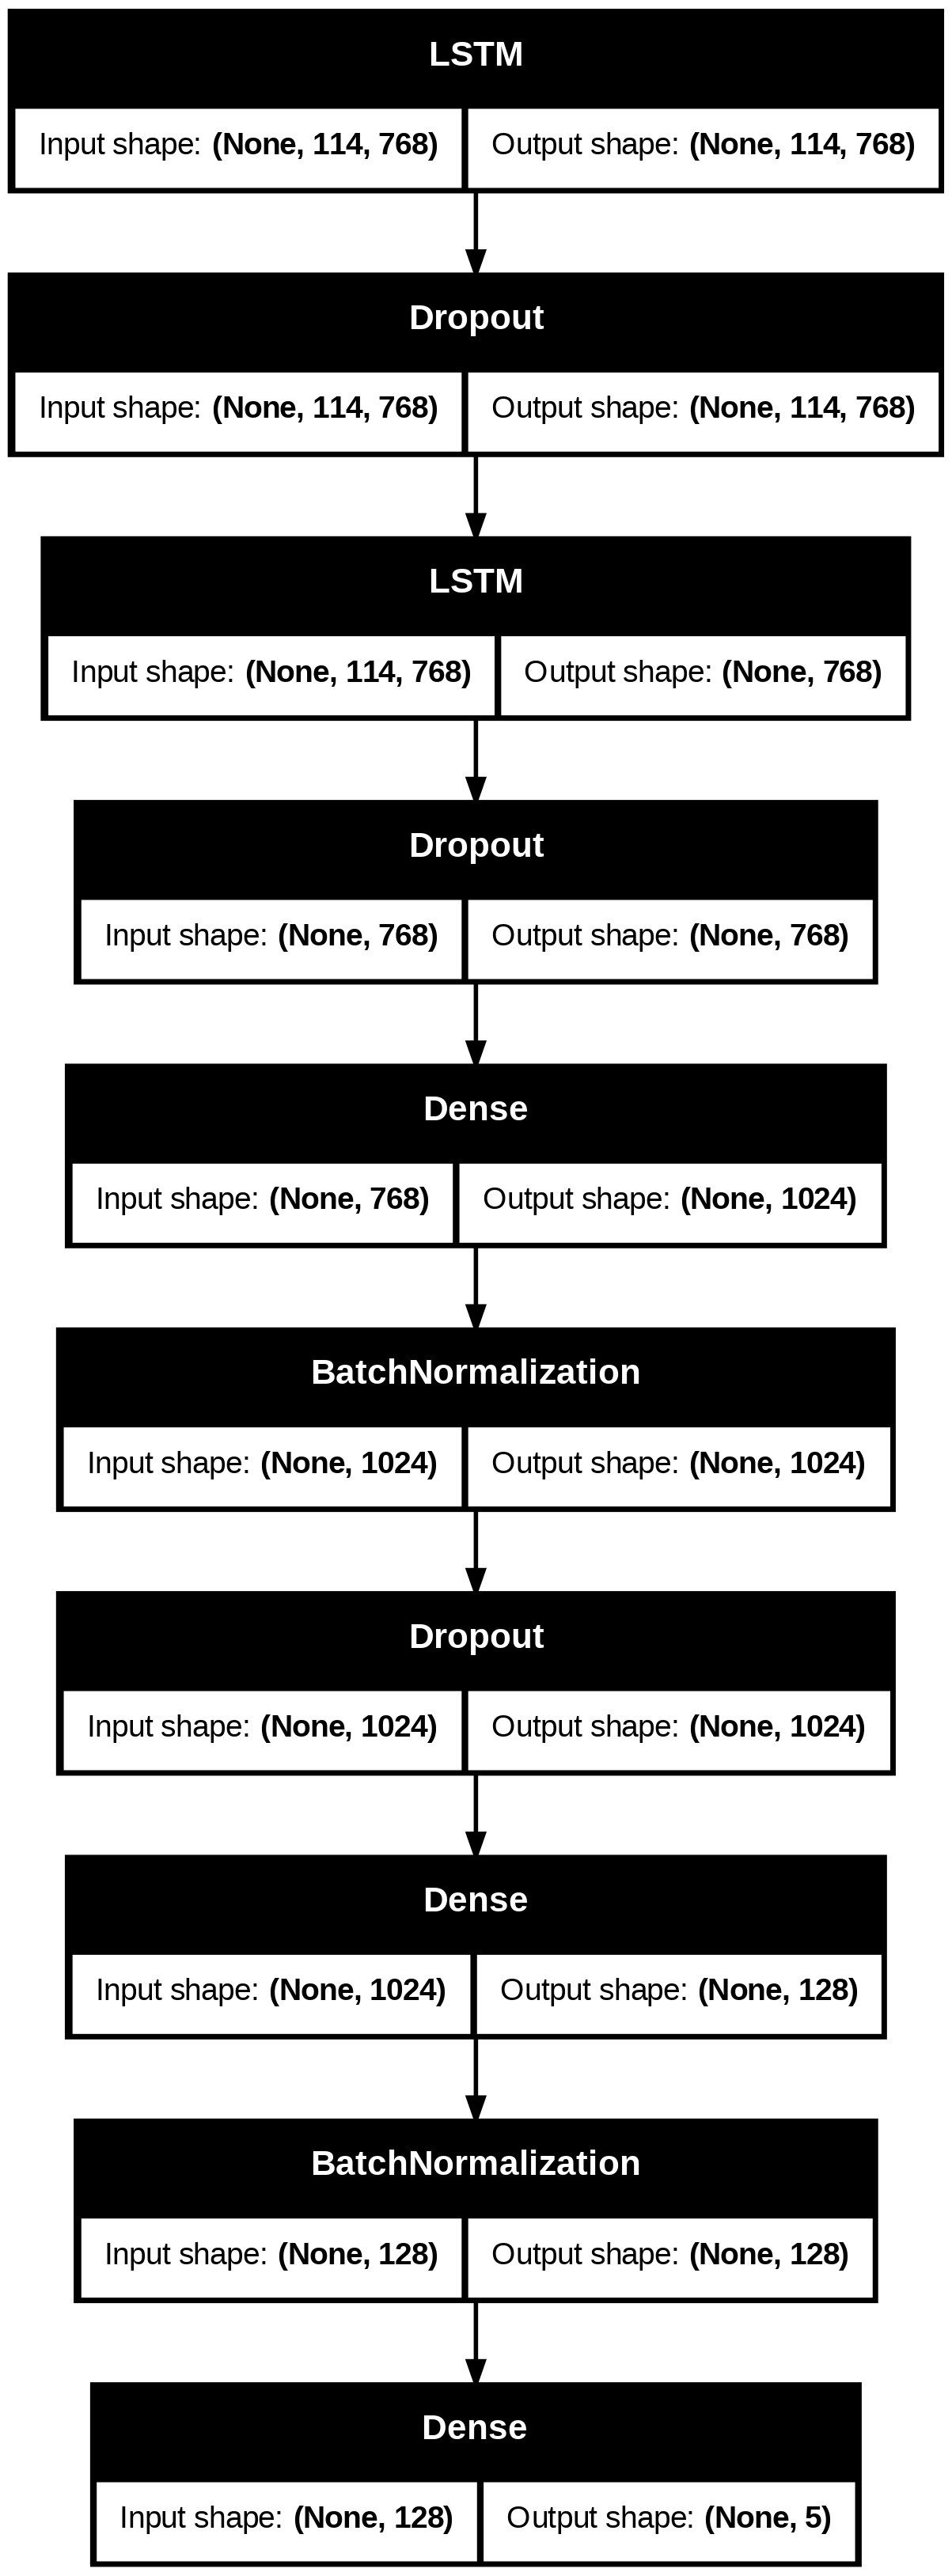

In [12]:
is_sequential = True

# Create model
def create_model(is_sequential):

    model = Sequential()

    if is_sequential:
      model.add(tf.keras.Input(shape=(114, 768)))

      model.add(LSTM(768,input_shape=(114, 768), activation=None, return_sequences=True))
      model.add(Dropout(0.2))

      model.add(LSTM(768, activation=None))
      model.add(Dropout(0.2))
    else:
      model.add(tf.keras.Input(shape=(768,)))

    # MLP
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(5, activation='sigmoid'))

    return model

model = create_model(is_sequential)
#print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

## **Leyendo la lista de archivos de entrenamiento, validación y prueba**

In [13]:
# Read the data lists

with open('train.txt', 'r') as f:
  train_list = f.readlines()
  for i in range(len(train_list)):
    train_list[i] = train_list[i].rsplit('\n',1)[0]

with open('validation.txt', 'r') as f:
  validation_list = f.readlines()
  for i in range(len(validation_list)):
    validation_list[i] = validation_list[i].rsplit('\n',1)[0]

with open('test.txt', 'r') as f:
  test_list = f.readlines()
  for i in range(len(test_list)):
    test_list[i] = test_list[i].rsplit('\n',1)[0]

## **Entrenando y evaluando nuestro modelo**

El modelo se entrena con el optimizador Adam, con una tasa de aprendizaje de 1e-5 y una función de pérdida de error cuadrático medio (L2). El tamaño del lote es 32, y el modelo se entrena durante 20 *epochs*. Se define un "callback" para guardar el mejor modelo entrenado en función del error absoluto medio observado en el conjunto de validación. Finalmente, se guarda el registro del historial en la ruta definida y se evalúa el modelo en el conjunto de pruebas.


In [15]:
# Training
import gc
import random
import pickle

lr = 1e-5
batch_size = 32
n_epochs = 20
checkpoint = './best_model_text_sequential.h5' if is_sequential else './best_model_text_avg.h5'
shuffle = True
verbose = 1

# creating data generators to load the data
train_dg = DataGenerator(train_list, './data_final/train/', is_sequence=is_sequential, batch_size=batch_size, shuffle=shuffle)
validation_dg = DataGenerator(validation_list, './data_final/validation/', is_sequence=is_sequential, batch_size=batch_size, shuffle=False)
test_dg = DataGenerator(test_list, './data_final/test/', is_sequence=is_sequential, batch_size=batch_size, shuffle=False)

# defining the optimizer
model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint + ".keras", monitor='val_mae', mode='min', save_best_only=True)

# training the model and saving the history
history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, callbacks=[mc])
with open('./train_history_text_sequential.pkl' if is_sequential else './train_history_text_avg.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 264ms/step - loss: 0.0858 - mae: 0.2411 - val_loss: 0.0361 - val_mae: 0.1507
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 244ms/step - loss: 0.0793 - mae: 0.2308 - val_loss: 0.0473 - val_mae: 0.1743
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - loss: 0.0755 - mae: 0.2256 - val_loss: 0.0432 - val_mae: 0.1657
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - loss: 0.0705 - mae: 0.2167 - val_loss: 0.0395 - val_mae: 0.1588
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - loss: 0.0682 - mae: 0.2135 - val_loss: 0.0432 - val_mae: 0.1665
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 245ms/step - loss: 0.0644 - mae: 0.2062 - val_loss: 0.0440 - val_mae: 0.1680
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - loss: 0.0612 - mae: 0.2008 - val_loss: 0.0427 - val_mae: 0.1661
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 244ms/step - loss: 0.0586 - mae: 0.1963 - val_loss: 0.0428 - val_mae: 0.1655
Epoch 9/20
124/124 ━━━━━━━━━━━━━

In [19]:
# Ceating/building our model again, and loading the last checkpoint (best model)
model = create_model(is_sequential)
model.load_weights(checkpoint + ".keras")
model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

# Evaluate the trained model on the test set

# Some house keeping
gc.collect()
tf.keras.backend.clear_session()

print('Evaluating on the test set')

_loss = 0
_mae = 0
for step in range(test_dg.__len__()):
  # Load the batch
  X, Y = test_dg.__getitem__(step)

  # validate on one batch
  loss, mae = model.evaluate(
      tf.convert_to_tensor(X, dtype=tf.float32),
      tf.convert_to_tensor(Y, dtype=tf.float32),
      verbose = 0)

  _loss += loss
  _mae += mae
step += 1
print("The final mean absolute error is {0:.5f}\n".format(_mae/step))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Evaluating on the test set
The final mean absolute error is 0.13932



## **Visualizando las curvas de entrenamiento**
- Pérdida de entrenamiento y validación, y MAE para cada *epoch*.
- Las curvas de entrenamiento pueden ayudarnos a entender un poco el comportamiento del modelo. Por ejemplo, si el modelo se está sobreajustando, o si el modelo aún estaba aprendiendo al final del entrenamiento, etc.

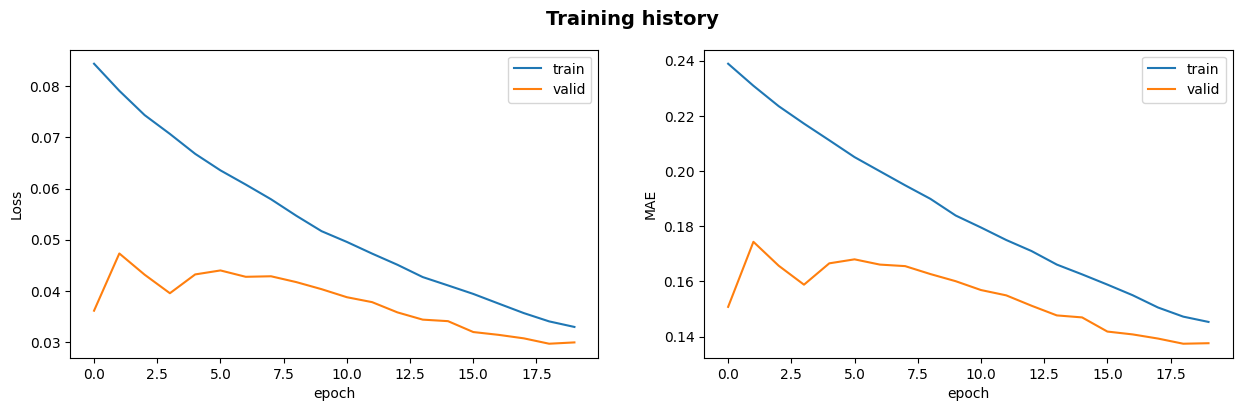

In [20]:
# Visualization
from matplotlib import pyplot as plt

# Load the history
train_hist = pickle.load(open('./train_history_text_sequential.pkl' if is_sequential else './train_history_text_avg.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')